In [1]:
from collections import OrderedDict
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# 전처리
def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')

  word_to_id = {}
  id_to_word = {}

  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word

  corpus = np.array([word_to_id[x] for x in words])
  return corpus, word_to_id, id_to_word

text = 'you say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)

[0 1 2 3 4 1 5 6]


### 동시발생 행렬
동시발행 행렬은 단어를 벡터로 표현하기 위한 첫번째 시도이다.
단어의 의미는 주변 단어에 의해 형성된다는 '분포 가설(distributional hypothesis)'에 기초하여 만들어진 기법이다.

In [6]:
def create_co_matrix(corpus, vocab_size, window_size=1):
  corpus_size = len(corpus)
  co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

  for idx, word_id in enumerate(corpus):
    for i in range(1, window_size + 1):
      left_idx = idx - i
      right_idx = idx + i

      if left_idx >= 0:
        left_word_id = corpus[left_idx]
        co_matrix[word_id, left_word_id] += 1

      if right_idx < corpus_size:
        right_word_id = corpus[right_idx]
        co_matrix[word_id, right_word_id] += 1
      
  return co_matrix

C = create_co_matrix(corpus, len(word_to_id))
print(C)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


### 코사인 유사도(cosine similarity)

코사인 유사도는 벡터 간 유사도를 구하는 가장 대표적인 기법이다.
이는 직관적으로 해석하자면, 두 벡터가 가리키는 방향의 코사인 값을 구하는 것이다.
두 벡터 사이의 각도가 작을 수록 값이 커진다.

In [7]:
def cos_similarity(x, y, eps=1e-8):
  nx = x / np.sqrt(np.sum(x**2) + eps)
  ny = y / np.sqrt(np.sum(y**2) + eps)
  return np.dot(nx, ny)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))

0.7071067758832467


### 유사 단어의 랭킹 표시

In [10]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
  if query not in word_to_id:
    print('%s을 찾을 수 없습니다.' % query)
    return
  
  print('\n[query] ' + query)
  query_id = word_to_id[query]
  query_vec = word_matrix[query_id]

  vocab_size = len(id_to_word)
  similarity = np.zeros(vocab_size)
  for i in range(vocab_size):
    similarity[i] = cos_similarity(word_matrix[i], query_vec)

  count = 0
  for i in (-1 * similarity).argsort():
    if id_to_word[i] == query:
      continue
    print(' %s: %s' % (id_to_word[i], similarity[i]))

    count += 1
    if count >= top:
      return

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067758832467
 i: 0.7071067758832467
 hello: 0.7071067758832467
 say: 0.0
 and: 0.0


### 통계 기반 기법 계산하기

동시발생 행렬의 원소는 두 단어가 동시에 발생한 횟수를 나타낸다. 그러나, 이 '발생' 횟수라는 것은 사실 그리 좋은 특징이 아니다. 예를 들어, 고빈도 단어 'the'와 일반 명사 'car'을 비교해 본다고 하자. 이 둘은 동시에 발생한 횟수가 꽤 많을 것인데, 이는 'the'와 'car'가 의미가 유사해서라기 보다는, 단지 'the'가 고빈도 단어이기 때문에 동시발생 횟수도 높게 나온 사례라고 할 수 있다.

이러한 문제를 해결하기 위해, 조건부확률을 사용하여 PMI 지수라는 것을 사용한다.

In [24]:
def ppmi(C, verbose=False, eps=1e-8):
  M = np.zeros_like(C, dtype=np.float32)
  N = np.sum(C)
  S = np.sum(C, axis=0)
  total = C.shape[0] * C.shape[1]
  cnt = 0

  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      pmi = np.log2(N * C[i, j] / (S[i]*S[j]) + eps)
      M[i, j] = max(0, pmi)

      if verbose:
        cnt += 1
        if cnt % (total // 100) == 0:
          print('%.1f%% 완료' % (100*cnt/total))

  return M

np.set_printoptions(precision=3)
W = ppmi(C)

print(W)

[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 차원 감소 (dimensionality reduction)

ppmi지수의 가장 큰 문제는 corpus의 크기가 커질 수록 단어의 벡터 길이도 같이
길어진다는 것이다. 따라서, SVD를 활용한 차원 감소 기법을 활용하뎌 단어의 벡터 길이를 줄여볼 것이다.

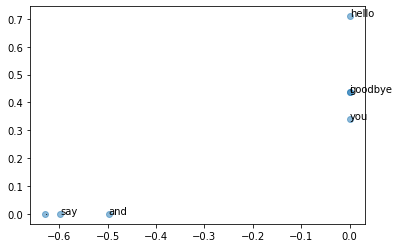

In [27]:
U, S, V = np.linalg.svd(W) # 차원 감소

for word, word_id in word_to_id.items():
  plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()